# Epidemic Model of an Aging Population

In this example we first create a model that has an independent demographic process occurring on top of the epidemic process, and then add on a mixing matrix to allow for mixing between age groups.

Before we get started we do import and setup.

In [1]:
import sys
sys.path.append('../')
import tabularepimdl as tepi

import pandas as pd
import numpy as np

## Simultaneous Demographic Process

First we will make a simultaneous demographic process that will have folks be born, age, and die in an process that is completely independent of the infectious process. Though there may be cases where order matters, if it can be mostly ignored at the timestep of interest, this process can be implemented in a separate rule set, that makes it clear that it is completely independent of the epidemic process

### Create an aging population

In [2]:
## For the first pass, let's create a population evenly distributed
## across multiple age groups.

#define global variables used by dataframes, class methods, etc.
start_age=0
end_age=70
age_step=5

age_struct_pop = pd.DataFrame({
    'DisState' : pd.Categorical(["S"]*15, categories=["S","I","R"]), #all categories are suscepitable
    'AgeCat': ["{} to {}".format(i, i+4) for i in range(start_age,end_age,age_step)]+["{}+".format(end_age)], #0-4, 5-9...65-69, 70+
    'N' : 100 #each group has 100 individuals
})

#now let's create a list of aging rules

aging_rules = [] #the list that will hold our aging rules

#Loop over all of the categories to "60 to 65" and put them into the
#next age group
for i in range (start_age,end_age,age_step):
    if i < end_age-age_step:
        tmp = tepi.SimpleTransition("AgeCat",
                                "{} to {}".format(i,i+4),
                                "{} to {}".format(i+5,i+9),
                                1/(365.25*5)) #age changing rate = 1/(5 years of 365.25 days)
    else:
        tmp = tepi.SimpleTransition("AgeCat",
                                    "{} to {}".format(i,i+4),
                                    "{}+".format(end_age),
                                    1/(365.25*5))
    aging_rules.append(tmp) #aging_rules eventuall has end_age/age_step = 14 rules
    
## Now let's add a rule for aging into the final category
#this individual append is not needed since the last rule is added in above for loop
#aging_rules.append(tepi.SimpleTransition("AgeCat","65 to 69", "70+", 1/(365.25*5))) #now aging_rules has 14 rules

##Now let's create a simple model with just these aging
##rules and run it for 10 years just to make sure it works.
agingPop = tepi.EpiModel(age_struct_pop, aging_rules) #passing cur_state and rules to EpiModel

##let's do one year of aging.
##lowest age group should be reduced by ~1/5, highest increased
##by 1/5...everyone else the same.
for i in range(365): # (1 - (1-np.exp(-1/(365.25*5))))^365 = about 0.81884, ~1/5 change
    agingPop.do_timestep(dt=1.0) #Each AgeCat's N gets updated each iteration, T increases 1 unit each iteration
    #from simpletransition: 1-np.exp(-dt*self.rate), np.exp() represents the remaining proportion, 1-np.exp() reprents the changed amount
print(agingPop.cur_state)



   DisState    AgeCat           N      T
0         S    0 to 4   81.884284  365.0
1         S  10 to 14   99.886270  365.0
2         S  15 to 19   99.994420  365.0
3         S  20 to 24   99.999781  365.0
4         S  25 to 29   99.999993  365.0
5         S  30 to 34  100.000000  365.0
6         S  35 to 39  100.000000  365.0
7         S  40 to 44  100.000000  365.0
8         S  45 to 49  100.000000  365.0
9         S    5 to 9   98.254413  365.0
10        S  50 to 54  100.000000  365.0
11        S  55 to 59  100.000000  365.0
12        S  60 to 64  100.000000  365.0
13        S  65 to 69  100.000000  365.0
14        S       70+  119.980840  365.0


### Add in births and deaths

For a true aging population we need folks not only to age, but also to be born and to die. Hence we will add in 
a birth and death process. First we will add these in not
worrying about our infectious process.

In [3]:
## Birth process...just make 10 per 1000 be born per year
simp_birth = tepi.BirthProcess(rate=10/(1000*365), start_state_sig=age_struct_pop.iloc[[0]], stochastic=False) #uses the yougest group as start_state_sig

##Death process...just make 20% of those in the oldest group die per year
simp_death = tepi.StateBasedDeathProcess(columns=["AgeCat"],
                                         states=["{}+".format(end_age)], #["70+"]
                                         rate=.2/365, stochastic=False)


##now les run before. We should have about 15 more people
##than before in the youngest group and a touch over 20 less in 
##the oldest.
agingPop = tepi.EpiModel(
    age_struct_pop,
    [aging_rules, [simp_birth], [simp_death]]
) #loads rule set (a list of lists) to EpiModel
  #each age group has certain individuals moved to next age group, yougest group has new borns, oldest group has death

#question: yougest group now has 95.4 people, oldest group now has 99.97 people, not align with 15 or 20 mentioned above? Is this right?

for i in range(365):
    agingPop.do_timestep(dt=1)

print(agingPop.cur_state)#question: the result does not line up with above expectation for youngest and oldest group, is this right?


   DisState    AgeCat           N      T
0         S    0 to 4   95.460457  365.0
1         S  10 to 14   99.971575  365.0
2         S  15 to 19   99.998606  365.0
3         S  20 to 24   99.999945  365.0
4         S  25 to 29   99.999998  365.0
5         S  30 to 34  100.000000  365.0
6         S  35 to 39  100.000000  365.0
7         S  40 to 44  100.000000  365.0
8         S  45 to 49  100.000000  365.0
9         S    5 to 9   99.563338  365.0
10        S  50 to 54  100.000000  365.0
11        S  55 to 59  100.000000  365.0
12        S  60 to 64  100.000000  365.0
13        S  65 to 69  100.000000  365.0
14        S       70+   99.977673  365.0


### Putting it all together: an outbreak in North Carolina

Now let's put this all together in an outbreak in a North Carolina like population that suddendly encounters a novel, and uncontrolled, measles like illness.



Let's first set out our demographic rules based on NC.

In [4]:
##First we lay out our population. The NC population distribution of 10 year age categories. 
start_age=0
end_age=70
age_step=10

nc_like_pop = pd.DataFrame({
    'DisState' : pd.Categorical(["S"]*8, ["S","I","R"]),
    'AgeCat': ["{} to {}".format(i, i+9) for i in range(start_age,end_age,age_step)]+["{}+".format(end_age)],
    'N' :[1140000, 1320000,1320000,1290000,1280000, 1280000,1185000,1175000],
    'T' : 2023 #question: do we want to assign T as an integer or float at the beginning?
})

## Now let's create some aging rules. Let's assume that a
## a timestep is a year in this case.
nc_aging_rules=[]
for i in range(start_age,end_age,age_step):
    if i < end_age-age_step:
        tmp = tepi.SimpleTransition("AgeCat", "{} to {}".format(i,i+9), "{} to {}".format(i+10,i+19), 1/10)#from 0 to 10, takes 10 years, so rate is 1/10
    else:
        tmp = tepi.SimpleTransition("AgeCat", "{} to {}".format(i,i+9), "{}+".format(end_age), 1/10)
    
    nc_aging_rules.append(tmp)

#nc_aging_rules.append(tepi.SimpleTransition("AgeCat","60 to 69", "70+", 1/10)) #replaced by above else statement

## Birth process
## New births come into the first row.
nc_birth = tepi.BirthProcess(rate=7/1000, start_state_sig=nc_like_pop.iloc[[0]], stochastic=False) #question: why use 1000 as denominator? Is it 7 new birth every 1000 people per year?

##Death process. Based on NC demographic data.
nc_deaths = [
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["0 to 9"], rate=1.5/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["10 to 19"], rate=.1/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["20 to 29"], rate=1/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["30 to 39"], rate=1.9/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["40 to 49"], rate=2.7/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["50 to 59"], rate=4.9/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"], states=["60 to 69"], rate=10.7/1000, stochastic=False),
     tepi.StateBasedDeathProcess(columns=["AgeCat"],states=["70+"], rate=43.9/1000, stochastic=False)
 ]





In [5]:
nc_like_pop

,DisState,AgeCat,N,T
0,S,0 to 9,1140000,2023
1,S,10 to 19,1320000,2023
2,S,20 to 29,1320000,2023
3,S,30 to 39,1290000,2023
4,S,40 to 49,1280000,2023
5,S,50 to 59,1280000,2023
6,S,60 to 69,1185000,2023
7,S,70+,1175000,2023


Now we will combine these with a simple SIR model. Note that the demographic rules and grouped separately from the
infection rules. This is how we ensure an independent process, as all of the updates for one grouping of rules will be made before the updates for the others. 

In [6]:
## Let's create one infected individual to get things started.
infect = pd.DataFrame({
    "DisState":"I",
    "AgeCat":"10 to 19",
    "N": [1],
    "T": 2023.0 #question: do we want to assign T as an integer or float at the beginning?
})

tmp = pd.concat([nc_like_pop,infect]).reset_index(drop=True)#question: can tmp be given a more meaningful name such as nc_like_pop_infected?
#tmp['T']=0                           

## Now we can define the epidemic model
NC_demo_epi = tepi.EpiModel(tmp, #should this parameter be nc_like_pop if we add infect person in for loop below?
                       [nc_aging_rules,
                        [nc_birth],
                        nc_deaths,
                        [tepi.SimpleInfection(beta=12*26, column="DisState"), #quesiton: what/why is 12*26 as infection rate?
                         tepi.SimpleTransition("DisState","I","R",26) #quesiton: what/why is 26 as transition rate?
                         ]]) #question, for simpleinfection, what does 12*26 mean? for simpletransition, what does 26 mean?

##And run it! In order to avoid extinction we will
##assume 1 case is imported every timestep
i=0
for t in np.arange(0,25,1/52): #quesiton: it is year 0 to year 25. tempstep is (1/52) year, about 1 week, correct?
    infect.T = 2023 + t #keep T updated with delta t
    if t==0: #the first iteration of the simulation
        NC_demo_epi.do_timestep(dt=1/52)
    else: #all other iterations of the simulation
        NC_demo_epi.cur_state=pd.concat([NC_demo_epi.cur_state,infect])
        NC_demo_epi.do_timestep(dt=1/52) #in each week (the timestep size), each age group moves certain people to next age group, some new birth join youngest group, some elders leave oldest group, some S people move to I people, some I people move to R people


Let's look at the results.

In [7]:
import plotly.express as px

nc_like_pop_infected = NC_demo_epi.full_epi.loc[NC_demo_epi.full_epi['DisState']=="I"]
nc_like_pop_infected = nc_like_pop_infected.assign(N=np.sqrt(nc_like_pop_infected['N']))

epi_fig = px.line(nc_like_pop_infected, x="T", 
                  y="N", color="AgeCat",
                  title="NC infected population in 25 years")

epi_fig.show()

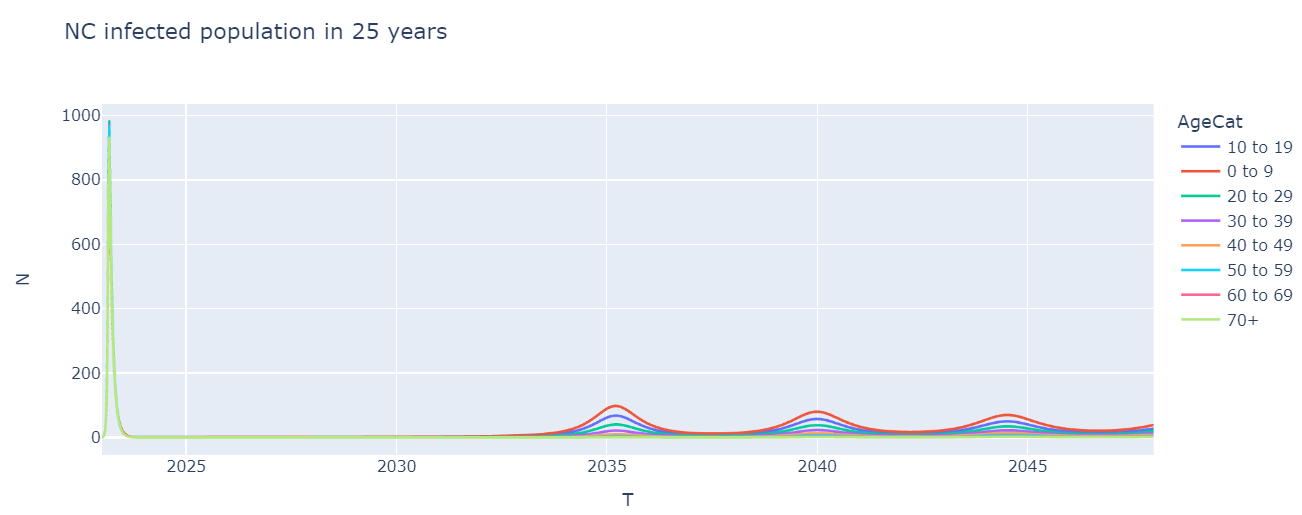

## Age specific mixing

Now that we have the ability to have demographics we we will also show how to add a rule where transmission occurs based on
an age specific mixing matrix. Note that the same rule could be used to do geography or other structured population
based models.

For this example we will use the following mixing matrix across our eight age categories, which we will reduce to
three. Under 20, 20-59, 60+. We will use a $\beta$ here that give an R0 equivalent to about 18 if everyone was the same age, half 
that one off the diagonal, and 1/4 that two off.

$$

\frac{(18)(26)}{N} \times
\left[
\begin{matrix}
1&1&0.5&0.5&0.5&0.5&0.25&0.25\\
1&1&0.5&0.5&0.5&0.5&0.25&0.25\\
0.5&0.5&1&1&1&1&0.5&0.5\\
0.5&0.5&1&1&1&1&0.5&0.5\\
0.5&0.5&1&1&1&1&0.5&0.5\\
0.5&0.5&1&1&1&1&0.5&0.5\\
0.25&0.25&0.5&0.5&0.5&0.5&1&1\\
0.25&0.25&0.5&0.5&0.5&0.5&1&1
\end{matrix}
\right] 
$$


In [8]:
##Let's define the WAIFW matrix
waifw = np.array([[1,1,0.5,0.5,0.5,0.5,0.25,0.25],
                  [1,1,0.5,0.5,0.5,0.5,0.25,0.25],
                  [0.5,0.5,0.25,0.25,0.25,0.25,0.5,0.5],
                  [0.5,0.5,0.25,0.25,0.25,0.25,0.5,0.5],
                  [0.5,0.5,0.25,0.25,0.25,0.25,0.5,0.5],
                  [0.5,0.5,0.25,0.25,0.25,0.25,0.5,0.5],
                  [0.25,0.25,0.5,0.5,0.5,0.5,1,1],
                  [0.25,0.25,0.5,0.5,0.5,0.5,1,1]]) 
#question: this above matrix includes values that are different than the ones displayed in markdown cell, which one is accurate?

waifw = waifw * 18 * 26 / nc_like_pop['N'].sum() #question: what is 26 for? 26-weeks or contact rate? why divide the population?
                                                 #how to make sense of this equation? 

## Now let's create our transmission rule from this
age_mix = tepi.WAIFWTransmission(waifw, "DisState","AgeCat")

#create one infected individual to get things started.
infect = pd.DataFrame({
    "DisState":"I",
    "AgeCat":"10 to 19",
    "N": [1],
    "T": 2023.0
})

nc_like_pop_waifw = pd.concat([nc_like_pop,infect])
nc_like_pop_waifw['AgeCat'] = pd.Categorical(nc_like_pop_waifw['AgeCat'])
print(nc_like_pop_waifw['AgeCat'].cat.codes)

## Set up the agemix_epi model
NC_agemix_epi = tepi.EpiModel(nc_like_pop_waifw,
                       [nc_aging_rules,
                        [nc_birth],
                        nc_deaths,
                        [age_mix,
                         tepi.SimpleTransition("DisState","I","R",26)
                         ]])

##And run it! In order to avoid extinction we will
##assume 1 case is imported every timestep
i=0
for t in np.arange(0,25,1/52):#quesiton: it is year 0 to year 25. tempstep is (1/52) year, about 1 week, correct?
    infect.T = 2023 + t #keep T updated with delta t

    #tmp = pd.concat([nc_like_pop,infect]) # question:=>this should be NC_agemix_epi.cur_state=pd.concat([NC_agemix_epi.cur_state, infect]), otherwise tmp stays the same every iteration
    #tmp['AgeCat'] = pd.Categorical(tmp['AgeCat']) #question:=>this should be NC_agemix_epi.cur_state['AgeCat']=pd.Categorical(NC_agemix_epi.cur_state['AgeCat'])
    #NC_agemix_epi.cur_state=tmp #question: with above tow changes, we should remove this line
    #NC_agemix_epi.do_timestep(dt=1/52)
    
    #fix for above questions: alternative solution to fix above issue
    if t==0: #the first iteration of the simulation
        NC_agemix_epi.do_timestep(dt=1/52)
    else: #all other iterations of the simulation
        NC_agemix_epi.cur_state=pd.concat([NC_agemix_epi.cur_state, infect])
        NC_agemix_epi.cur_state['AgeCat']=pd.Categorical(NC_agemix_epi.cur_state['AgeCat'])
        NC_agemix_epi.do_timestep(dt=1/52)


0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
0    1
dtype: int8


In [9]:
NC_agemix_epi_infected = NC_agemix_epi.full_epi.loc[NC_agemix_epi.full_epi['DisState']=="I"] #only look at I people, full_epi has (25-0)*((25-0)*52) about 31200 records
NC_agemix_epi_infected = NC_agemix_epi_infected.assign(N=np.sqrt(NC_agemix_epi_infected['N'])) 
NC_agemix_epi_infected

,DisState,AgeCat,N,T
8,I,10 to 19,1.000000,2023.000000
9,I,0 to 9,1.012545,2023.019231
10,I,10 to 19,1.339065,2023.019231
11,I,20 to 29,0.771476,2023.019231
12,I,30 to 39,0.761923,2023.019231
...,...,...,...,...
31182,I,30 to 39,12.011169,2048.000000
31183,I,40 to 49,8.085207,2048.000000
31184,I,50 to 59,5.068475,2048.000000
31185,I,60 to 69,2.415138,2048.000000


In [10]:
epi_fig_agemix = px.line(NC_agemix_epi_infected, x="T", y="N", color="AgeCat", title='NC infected population in 25 years') #add a title for the graph
epi_fig_agemix.show()

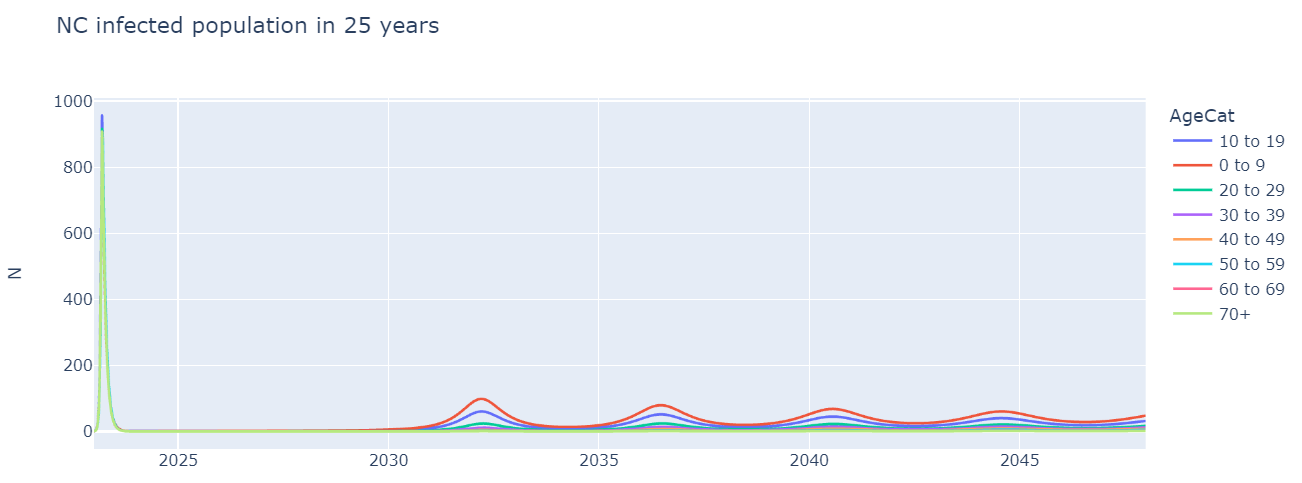